{[Click here to read this notebook in Google Colab](https://colab.research.google.com/drive/1ngO6DHiSbn_bW8b8zpY1aCbu04lwn1ef)}

<head><link rel = "stylesheet" href = "https://drive.google.com/uc?id=1zYOH-_Mb9jOjRbQmghdhsmZ2g6xAwakk"></head>

<table class = "header"><tr>
    <th align = "left">EPAT Batch 45 | Backtesting, May 2020</th>
    <th align = "right">Written by: Gaston Solari Loudet</th>
</tr></table>

## Practice exercises

Following my proposal of the final project, I intend to use this exercise as a project teaser, but also as a means to implement the [MetaTrader 5 wrapper library](https://www.mql5.com/en/docs/integration/python_metatrader5). Its main advantage, aside from real-time trading itself, is that "<code>MT5</code>" brokers are usually also free data providers. Therefore, backtesting data for this assignment can be directly obtained from it.

For these exercises, I will be backtesting the last 2 weeks of the Spanish Exchange Index ("[IBEX-35](https://en.wikipedia.org/wiki/IBEX_35)") index data. By the way, the reader might not have a broker account for MT5. Therefore, in this particular case, I will solve these exercises just with Ran Aroussi's popular Yahoo! Finance API which is included as feature in my ``Backtest``ing model. Speaking of which: I will make use of a "``Backtest``" object that I've coded for this purpose. Such holds the ad-hoc procedure for a typical vectorized backtesting task: data download, clean-up, indicator & signal calculation, plotting and performance stats.

I've decided to recreate the model from a Jupyter Notebook ("``.ipynb``") to a Python file ("``.py``") to increase execution speed.

In [1]:
import numpy, pandas, matplotlib, ta, scipy.stats, yfinance, datetime, itertools, ProgBar
from IPython.display import display
from Backtest import Backtest
# Preset (dark) plot properties.
matplotlib.pyplot.style.use("https://drive.google.com/uc?id=1TawPXELPzNlySaOx3HT67A-wHwRxuWjQ")
pandas.plotting.register_matplotlib_converters()
pandas.options.display.max_columns = None
colors = matplotlib.cm.ScalarMappable()

We will simulate our backtesting in a retail trading account of the following specifications:
* Initial ``cap``ital: ``1000`` USD. Common starting funds for first-time testing a strategy execution in real market.
* Standard trade's ``lot`` size: ``1/100``. So that an IBEX's point (0.01 USD) in our favour, would generate a cent of profit.
* ``Lev``erage: ``72``. An IBEX long trade of ``1/100`` lot, would imply a margin of about 100 USD these days; 1/100th of our ``cap`` (margin level = 100)
* For each USD that we earn, we will ``reinv``est ``1/4``th of it to proportionally enlarge future trade sizes.

For each of the following exercises, a copy of our original "``data``" will be created so as to start clean each exercise. We will be analyzing the different strategy throughout the last 14 days since this notebook is executed. Feel free to change the ``datetime``s ("``t``" and "``dt``") as wished.

In [2]:
%%capture
Account = {"cap": 10000, "lev": 72, "lot": 0.01, "reinv": 1/4} ## Account details (funds, leverage, etc.)
t, dt = datetime.datetime.now(), datetime.timedelta(days = 365*4) ## Last date in history, Lookback days
Original_Data = Backtest(name = "Original data") ## Create backtesting instance. Exercises will clone this.
Original_Data.load_data(symbols = ["^IBEX"], dates = (t - dt, t), frame = "D1", source = "yfinance")
symbol = Original_Data.Specs.columns[0] ## Leftmost symbol: Signals triggered in IBEX.
dataset = Original_Data.Data.columns[0][0] ## Leftmost dataset: Indicators calculated on IBEX, at frame M5.
n = 3   ;   show = numpy.r_[0 : n, -n : 0] ## When displaying Data and Trades' dataframes, show first and last "n" rows.

Keep in mind that from now onwards, the backtesting procedure of each strategy in this task, follows the same vein as in the "``Backtest.ipynb``" structure. **I strongly recommend reading at least a bit of that file**. So basically, we first ``clone`` the main dataframe, and then...

1. <u>We calculate our needed indicators.</u>
<br>They don't really need to be exactly classical indicators from technical analysis, but rather should include any type of data that is calculated based on available data, and may be necessary for trading signal settling (for example, one could just be a counter of the amount of recently continuous bull days...)
<br><br>
There's no class method for this, because indicators may vary in terms of arguments, lookback periods, and dataset features. So therefore, our indicators may be directly calculated on the market history ``.Data`` frame in every exercise.
<br><br>
2. <u>We settle the signals and the logic behind them.</u>
<br>We use the "``load_signal``" function for that, completely described in such file. There are 4 kinds of signals: <br>Go ``L``ong & ``B``uy ("``LB``"), go ``S``hort & ``S``ell ("``SS``"), exit the ``L``ong & ``S``ell what was bought (``LS``), or exit the ``S``hort & ``B``uy what was sold ("``SB``").
<br><br>
<u>What do we need for that?</u>
<br>Each signal needs a conditional ``rule``, and a signal ``trig``gering price at which the corresponding trade will open. Also, the ``size`` of the trade-to-be may be calculated based on indicators too, so we may require a function for that as well. However, to simplify things in this task, we may always use "``size = 1``".
<br><br>
3. <u>We set the stop loss and stop profit rules</u>
<br>Though we won't use them in this case, I strongly recommend exploring the background file.<br><br>
4. <u>We simulate the system and see the results</u>
<br>We first run the "``test_strategy``" function for the resulting trade history: open and close times/prices, directions, size and cause of exit.
<br>Then we run the "``test_balance``" function to calculate all financial concerns of such trades, given a certain set of our "``Account``" values.
<br>Finally, we apply the "``test_stats``" function to work out a statistical summary of them: mean, standard deviation, performance ratios, etc.
<br><br>
5. <u>We plot the results</u>
<br>Some pre-made graphing functions have been made in "``Backtest.ipynb``". One for plotting the price chart and signals/trades, another for visualizing the profit and margin curve through time, and a third one that draws different histograms of trade distribution bins according to trade score, profit, size and returns.

<hr><hr><hr>

### Exercise 1

> Backtest a strategy using three moving averages on any indices such as Nifty50, SPY,
HSI and so on...

> * Compute three moving averages of 20, 40, and 80 periods.
> * Go long when the price crosses above all three moving averages.
> <br>Exit the long position when the price crosses below any of the 3 moving
averages.
> * Go short when the price crosses below all three moving averages.
> <br>Exit the short position when the price crosses above any of the three moving
averages.
> * <u>Optional</u>: Optimize all three moving averages.

I'd first like to clarify that though this is clearly a moving average crossover strategy, it's also a **price band** strategy because of the ``L``ong and ``S``hort ``rule``s: as the price must go above or below all MAs, it can be interpreted as if the MAs form a price band very much alike the Bollingers, and that if the price goes outside from it, a signal may settle.

Therefore, I find it very convenient to establish a separate pair of "indicators"; "``MA_max``" and "``MA_min``", which store the highest and lowest value that **any** moving average has reached in a determined point in time. This is because if the price has gone above/below all moving averages, then the logical statement would be that the price has surpassed the maximum/minimum value of the moving average set. These band lines will be better visualized in the plot below.

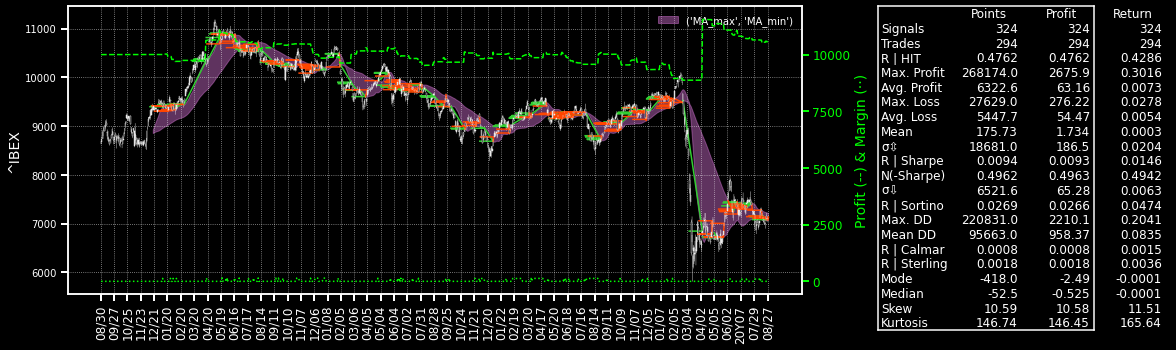

In [3]:
def Exercise_1(SMAs):
    ####################################################################################### Indicators.
    X = Original_Data.clone(name = "[Exercise 1] 3 moving averages")
    for SMA in SMAs: ## Calculate each SMA indicator with periods inside "SMAs" list.
        digits = X.Specs.loc["digits", symbol]
        X.Data[("Indicators", f"SMA_{SMA}")] = X.Data[(dataset, "Close")].rolling(int(SMA)).mean().round(digits)
    X.Data[("Indicators", "MA_min")] = X.Data["Indicators"].min(axis = "columns", skipna = False)
    X.Data[("Indicators", "MA_max")] = X.Data["Indicators"].max(axis = "columns", skipna = False)
    ####################################################################################### Signals.
    f_LB = lambda x: (x["Indicators"]["MA_max"] <= x[dataset]["High"]) # Price raises above all MAs.
    p_LB = ("Indicators", "MA_max") # Highest MA value is the one entering long when crossed... (LB = buy long)
    f_SS = lambda x: (x["Indicators"]["MA_min"] >= x[dataset]["Low"])  # Price falls below all MAs.
    p_SS = ("Indicators", "MA_min") # Lowest MA value is the one entering short when crossed... (SS = sell short)
    f_LS = lambda x: (x["Indicators"]["MA_max"] >= x[dataset]["Low"])  # Price raises above any MAs.
    p_LS = ("Indicators", "MA_max") # Highest MA value is the one exiting a long when touched... (LS = sell long)
    f_SB = lambda x: (x["Indicators"]["MA_min"] <= x[dataset]["High"]) # Price falls below any MAs.
    p_SB = ("Indicators", "MA_min") # Lowest MA value is the one exiting a short when touched... (SB = buy short)
    # Note: Don't change "f_size" if wishing to increase all trade sizes. Directly increase "lot" in "Account".
    X.load_signal(symbol, dire = "LB", trig = p_LB, rule = f_LB)
    X.load_signal(symbol, dire = "SS", trig = p_SS, rule = f_SS)
    X.load_signal(symbol, dire = "LS", trig = p_LS, rule = f_LS, strict = False)
    X.load_signal(symbol, dire = "SB", trig = p_SB, rule = f_SB, strict = False)
    ####################################################################################### Strategy testing.
    X.test_strategy(max_trades = 1)   ;   X.test_balance(**Account)   ;   X.test_stats()
    ####################################################################################### Results.
    return X
## Strategy test.
X1a = Exercise_1(SMAs = [20, 40, 80]) ## Change SMA period values in this list.
Fig1a = X1a.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
X1a.plot_indicator(axes = Fig1a.axes[0], labels = ("MA_max", "MA_min"), color = "violet", alpha = 0.4);

Though most of the framework is deeply described in the "``Backtest.ipynb``" file, we will now detail a few things as this is the first exercise.

The "``plot_complete``" function creates a two-part figure like the one above. The left part being the price chart itself, and the right part showing a table with the resulting "``Stats``" of the strategy backtest. The former can draw entry ``signals`` as blue (buy) or red (sell) dots, and also ``trades`` as green (profit) or red (loss) lines. To create a "zoomed" version of this chart in, for example, the middle third of the entire timeline, we can add the "``t1 = 1/3``" and "``t2 = 2/3``" arguments to the "``plot_complete``" function (or "``plot_chart``" to avoid the ``Stats`` table).

Projected against the rightmost secondary axes, the ``profit`` curve is drawn in dashed green, starting from the initial ``cap``ital (funds, 1000 USD as agreed). The margin curve is drawn in dotted green below. Well, in fact it should run below at all times, or else the strategy would be causing big trouble! This is better discussed on the class document but as all trades have the same size, the occupied margin in our broker would also be equal in all cases.

The "``plot_indicator``" function overlaps the indicator plot on top of a specified chart. In this exercise, we ought to draw the band between "``MA_max``" & "``MA_min``" in ``violet`` (which as already specified, it conceptually encloses all three SMAs). If the ``axes`` are not specified, the indicator is created on a separate graph. See that the trades are born on points where the price candle sticks out of the band strip, as the strategy dictates.

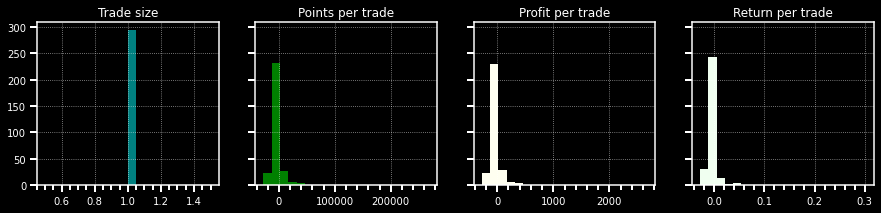

In [4]:
Fig1h = X1a.plot_histogram(symbol = symbol, profit = True, ret = True, bins = 20)   ;   Fig1h.set_figheight(3)

The "``plot_histogram``" tool is quite self-explanatory: it stacks the trades, showing their distribution in terms of the different used measuring contexts. If trade size is kept as 1, all trades would lean on the column on bin 1 in "Trade size" histogram, and "Points per trade" would display the same histogram as "Profit per trade" due to all having the same proportionality. If no ``reinv``estment fraction is imposed, "Return per trade" histogram would also have the exact same format.

On the other hand, notice that if the strategy has a variable trade size and a ``reinv``estment fraction, the winning/losing effect will be amplified, and the most densely stacked areas in these graphs would become more skewed to the right/left respectively. This phenomenon can be taken advantage of, so as to optimize trade sizing and reinvestment values.

In [5]:
ttl = "Trades: points, PnL & margin summary"   ;   print(ttl + "\n" + "‾"*len(ttl))   ;   display(X1a.Trades.iloc[show])

Trades: points, PnL & margin summary
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


Time               Price             Sym Dir Size     Sink   Cause  \
          Open      Close     Open    Close                                    
0   2017-01-11 2017-01-12  9391.84  9395.64  ^IBEX   L    1  9343.00  Signal   
1   2017-01-12 2017-01-16  9395.64  9413.76  ^IBEX   L    1  9395.64  Signal   
2   2017-01-16 2017-01-17  9413.76  9412.87  ^IBEX   L    1  9361.90  Signal   
291 2020-08-18 2020-08-24  7133.17  7080.10  ^IBEX   S    1  7133.17  Signal   
292 2020-08-24 2020-08-25  7080.10  7108.40  ^IBEX   S    1  7215.10  Signal   
293 2020-08-27 2020-08-28  7073.74  7133.00  ^IBEX   S    1  7162.90  Signal   

    Points               Profit                     Return         Margin  \
                Σ   Sink                Σ   Abs.DD         Rel.DD           
0      379    379   4884   3.79  10003.79     0.00   0.03%   0.0%  130.44   
1     1812   2191      0  18.12  10021.91     0.00   0.18%   0.0%  130.49   
2      -89   2102   5186  -0.90  10021.02     0.89  -0.01%   0.0%  130.74   
291   5306  60422      0  53.08  10598.71   948.34    0.5%  8.21%   99.07   
292  -2830  57592  13500 -28.34  10570.37   976.68  -0.27%  8.45%   98.33   
293  -5927  51665   8915 -59.24  10511.14  1035.91  -0.57%  8.97%   98.24   

                     
          Σ   Level  
0    130.44   7628%  
1    130.49   7666%  
2    130.74   7625%  
291   99.07  10644%  
292   98.33  10640%  
293   98.24  10668%

This dataframe just above, shows (<u>**a few of**</u>) the trades that were born from applying the strategy in a sequential and event-driven manner on our datasets/signals/indicators. Most details are clarified on the "**Strategy testing**" section of the class document. However, a few things to recall:
* "``Dir``" tells if the trade was ``L``ong or ``S``hort.
* "``Sink``" tells the farthest away that the price went (negatively) from the entry point, while the trade was active.
* "``Cause``" tells why did the trade close/exit. As we do not have stop values, this case would always include ``Signal`` exits.
* The "``Points``" section measures price difference in points, which are a measure for the minimal amount that the instrument price can change. For example: in S&P 500, a point is 0.25 USD. If I went short at 3000 USD and I re-bought at 2999 USD, I earned 4 points.
* The "``Profit``" section measures profit in currency units. There is a currency value for every earned point, depending on broker standards, and the trade size. Then, we can convert the earned points into earned profit.
* The "``Return``" section shows the compound return from the currency ``Profit``, based on initial capital. It can also be a source for finding "``DD``" (drawdown).
* The "``Margin``" section measures credit risk as a result of trading under leverage. Please, refer to the "``Backtest.ipynb``" for a deep analysis of this.

In [6]:
ttl = "Price/volume dataset, signals & indicators"   ;   print(ttl + "\n" + "‾"*len(ttl))   ;   display(X1a.Data.iloc[show])

Price/volume dataset, signals & indicators
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


Symbol     ^IBEX D1                                     ^IBEX               \
Value          Open    High     Low   Close     Volume Spread  LB       SS   
Date                                                                         
2016-08-30   8629.4  8731.9  8629.0  8685.4  155905500    0.0 NaN      NaN   
2016-08-31   8677.4  8780.7  8671.4  8716.8  297356800    0.0 NaN      NaN   
2016-09-01   8746.3  8884.9  8730.8  8762.8  300780300    0.0 NaN      NaN   
2020-08-26   7088.4  7136.5  7070.4  7123.0  122064500    0.0 NaN      NaN   
2020-08-27   7114.1  7130.2  7029.2  7090.7  162183000    0.0 NaN  7073.74   
2020-08-28   7114.7  7162.9  7055.1  7133.0  193354900    0.0 NaN  7086.52   

Symbol                      Indicators                                      
Value           LS       SB     SMA_20   SMA_40   SMA_80   MA_min   MA_max  
Date                                                                        
2016-08-30     NaN      NaN        NaN      NaN      NaN      NaN      NaN  
2016-08-31     NaN      NaN        NaN      NaN      NaN      NaN      NaN  
2016-09-01     NaN      NaN        NaN      NaN      NaN      NaN      NaN  
2020-08-26  7123.0  7123.00    7069.04  7225.44  7190.14  7069.04  7225.44  
2020-08-27  7090.7  7073.74    7073.74  7215.25  7194.64  7073.74  7215.25  
2020-08-28  7133.0  7086.52    7086.52  7208.48  7199.01  7086.52  7208.48

This upper dataframe can be divided into 3 parts from left to right: the <u>dataset</u>, the <u>signals</u> and the <u>indicators</u>.

* The dataset is just the market data. We may have market data for many instruments/symbols, and we may have also market data for different timeframes (time steps) of a same symbol. For example, we may want to calculate indicators on a dataset of 1 hour per row, but may wish to see what happens to price, minute by minute. This usually happens with market in reality itself.
* There is one signal block per instrument, with the instrument symbol name as header (e.g.: "``IBEX``"). For every row in history, each signal (long or sell, entry or exit) is a tuple with leftmost value as entry price (always calculated with max precision, ergo, taking prices from the dataset with the lowest time step), and the trade size calculated by the size function. When there is no signal for trade because the ``rule`` didn't return a valid entry, the tuple holds NaN.
* The ``Spread`` is also kept on the signal block, because when opening a trade, we record the signal price (tuple's leftmost), to which we have to subtract the ``Spread`` to obtain the real entry bid/ask price.
* The ``Indicator`` section lies on the rightmost border. Values may be rounded to 2 or 3 decimals, depending on with which amount of decimals does the broker display the instrument price.

<hr>

### Optimizing function

So along this work, we will usually need to find the best combination of indicator parameters for different predictive models. We will then use the following "``optimap``" method which will plot these combinations in 2-dimensional maps so as to locate an optimal point in somewhere.

Most exercises are going to feature ``def`` functions of the form: "``Exercise_``**#**". For example, our actual "``Exercise_1``" function whose argument is the "``SMAs``" period array. What the "``optimap``" will need as input, is this function but re-expressed as a ``lambda`` object (``f_xy``), with exactly 2 arguments defined as symbolic variables for their further optimization.

The function will basically consist in 3 parts:

<u>**Part 1**</u>
* The creation of a dataframe <u>``G``rid</u> whose rows and columns hold the different test values for the 2 chosen arguments.
* These 2 arrays of argument test values are labelled "``X_params``" & "``Y_params``".
* These ``params``' arrays can be numeric (like SMA periods: "``[2, 4, 6, ...]``") or can be labelled configurations (like ``go long``, ``go short``, ``go both``, etc.).
* On the latter case, ``params`` will hold a ``dict`` ("``{keys: values}``") with ``keys`` as the string ``labels`` that try to describe each configuration, and ``values`` holding the non-numerical argument values for the analyzed ``Exercise`` function. This is better seen on exercises 2 and 5.
* The ``G``rid will compile one whole "``X_params``" vs "``Y_params``" sub-dataframe for each one of the ``Stats`` in which we'll focus our optimization.

<u>**Part 2**</u>
* ``For`` each argument combination of "``X_params``" and "``Y_params``", we will ``try`` to backtest the strategy.
* Each backtest is run with the "``f_xy``" function that stores the ``Exercise`` itself, but with both optimizable arguments as lambda variables.
* The "``f_xy``" function returns the resulting ``Backtest`` object. We just need to copy the ``.Stats`` dataframe from it.
* From the ``S`` stats' copy, we retrieve each of the ``stats`` in which we are interested, and paste them in the ``Grid``.
* Notice that I used a "``try``" keyword because if the strategy returns no trades, then ``.Stats`` comes out as empty and might return an ``assert``ion error.

<u>**Part 3**</u>
* We create a ``Figure`` with as many ``Axes`` (``subplots``) as ``Stats`` we are interested in.
* If we want to display graphs as heatmaps, a ``contour`` map is plotted on the 2D xy-params plane (``meshgrid``).
* If we wish to display graphs as line plots because one of both ``params``' arrays is not numerical, we draw one curve per labelled case.
* ``Inf``inite ``stat``s may be consequence of a null denominator (e.g.: Sortino, because of having no losing trades). We need to ``NaN`` them, so as to avoid infinite values in the graphs (``lim``its which span the y-axis may otherwise overshoot while drawing line plots).

In [7]:
def optimap(f_xy, X_params, Y_params, heat = True, symm = False):
    Stats = ["Trades", "Mean", "R | Sharpe", "R | Sterling"] ## Around which statistical metrics are we going to optimize.
    arrays = (list, tuple, dict, range, numpy.ndarray, pandas.Series) ## Indexable arrays for "X" & "Y" parameter arguments.
    assert isinstance(X_params, arrays) and isinstance(Y_params, arrays), "{TYPE} 'X' & 'Y' params must be indexable arrays."
    X_labels, Y_labels = X_params, Y_params ## "Grid" df's index/column labels may tentatively be the parameters themselves.
    ## However, if "X"/"Y" params' array is a dict, keys will be column labels in Grid. Values will be arguments for "f_xy".
    if isinstance(X_params, dict): X_params, X_labels = list(X_params.values()), list(X_params.keys())
    if isinstance(Y_params, dict): Y_params, Y_labels = list(Y_params.values()), list(Y_params.keys())
    Grid = pandas.DataFrame(index = X_labels, columns = pandas.MultiIndex.from_product(iterables = (Stats, Y_labels)))
    Combs = list(itertools.product(range(len(X_params)), range(len(Y_params)))) ## Indexes of all possible "X" & "Y" pairs.
    ## In cases where "X" & "Y" share exact same indicator nature (e.g.: both SMA), omit repeated/swapped cases. Example:
    if symm: Combs = [(nx, ny) for nx, ny in Combs if (X_params[nx] <= Y_params[ny])] ## "(p1, p2) = (p2, p1)". Keep just one.
    Prog = ProgBar.ProgBar(steps = len(list(Combs))) ## Create a progress bar made with characters.
    ## For given parameters "x" and "y", we will run the exercise, find its stats and create a 2D grid.
    for nx, ny in Combs: ## For every combination of parameters.
        x_param, y_param, x_label, y_label = X_params[nx], Y_params[ny], X_labels[nx], Y_labels[ny]
        try: ## Run the exercise with a function as specified.
            S = f_xy(x_param, y_param).Stats[symbol]["Return"] ## From the backtest results, keep only the returns' ".Stats".
            for stat in Stats: Grid.loc[x_label, (stat, y_label)] = S[stat]
        except: 1 ## When it's impossible to calculate stats (e.g.: no signals/trades), forget about errors.
        Prog.up() ## Increase progress bar.
    Figure, Axes = matplotlib.pyplot.subplots(ncols = len(Stats))
    ## Heatmaps will display the most optimal spots in red.
    Grid.replace(to_replace = [-numpy.inf, numpy.inf], value = numpy.nan, inplace = True)
    for n, stat in enumerate(Stats):   ## Infs ⇧ when denominator is 0.
        lim = max(abs(Grid[stat].min().min()), abs(Grid[stat].max().max()))*1.25  ## Y-axes' max span for lines.
        if heat: Axes[n].contourf(*numpy.meshgrid(X_params, Y_params), Grid[stat].values.T); # Heatmap, 2D.
        else: Grid[stat].plot(ylim = [-lim*(Grid[stat] < 0).any().any(), lim], ## When no negative numbers found...
                              ax = Axes[n], legend = False, linewidth = 2.5);  ## ...lowest y-axis point can be 0.
        Axes[n].set_title(stat, fontweight = "bold")
    if not(heat): Axes[0].legend(fontsize = 13) ## Add legend just to the first line plot.
    matplotlib.pyplot.pause(1e-13) ## This line avoids a (quite loooong) Tkinter warning print.
    return Figure, Grid

We will try to find the optimal combination for our 3 SMAs. But first: notice that in a moving average crossover strategy, the ones with the lowest and highest lookback periods are the ones which lead the trend at most times: the middle one does not go below or above the other two, very regularly.

That is because:
* <u>On a trend</u>: The short-term one ("``X_params``") is the most sensitive, and will react going high/low immediately after the price rises/falls. The longest-termed one ("``Y_params``"), on the contrary, is the most lagged, and will be the slowest to rise/fall. The middle one will always lay in the middle.
* <u>On a range</u>: The short-term one ("``X_params``") will always oscillate with the largest volatility/frequency, on parallel to the price. The long-term one ("``Y_params``") will present almost no reaction, and will run horizontally. The middle one will fluctuate covering the middle ground, but the band area will almost always be traced by the short-term moving average.

We will therefore set the middle-term moving average's period to be at the mid point between each ``x`` and ``y``: "``(x + y)/2``". See how the "``f_xy``" function is specified in this case. Also, we include a ``symm``etry parameter which aims to omit repeated SMA combinations. For example: if both "``X_params``" and "``Y_params``" include values ``20`` and ``30``, our ``optimap`` might want to backtest both "``(20, 30)``" and "``(30, 20)``". But both combinations are the same because they correspond to the same indicator types. So: why don't we save some time by skipping one of them?

In [8]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_1(SMAs = [x, (x + y)/2, y])
Fig1o, Grid1 = optimap(f_xy = f_xy, X_params = range(2, 7, 2), Y_params = range(4, 12, 2), symm = True);

UsageError: Line magic function `%` not found.


I felt interesting to backtest this instrument during these last 4 years (August 2016-2020). That's because each year had its own structure. As a brief summary: (2017) steep **uptrend**, (2018) soft **downtrend**, (2019) mostly horizontal/**range**, and (2020) **PANDEMICS!!!** Consider that Spain had its infection rate peak throughout all February, so it was then when the IBEX crashed (around 35%).

So I tried a significantly widely spread and refined range of SMA combinations around the 10-100 gamut. The results are...

<center><img src = "https://drive.google.com/uc?id=1YFhPYOf4ePblbqMLYmu1kBstd4T0RNBz" width = "100%"></img></center>

At first sight, we can notice a huge black area. Well, that's because of skipping the equal SMA combinations. However, there are also some "black cuts" along the "``y = x``" line. These precisely coincide with all SMAs being equal. This usually happens when we divide zero by zero. ``Mean`` being NaN is consequence of zero net profit and zero trades. This cases didn't generate trades because the price "candlestick" (the range of prices in a row of data) is never a single point, so therefore we had never seen a moment during the backtest, where the price was crossing above the SMA band without having the same candle crossing below the SMA at a certain point in time during the same row. In my ``backtest`` class, for risk-aversion reasons, I particularly coded opposite signals to cancel each other and not open any trade.

We do have 2 warm spots of higher means and ratios: around the 3-5 region, and around 50-55. Consider that because of the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_Large_Numbers), long-term standard deviation of individual trade outcomes lowers by a factor equal to the square root of the amount of them. The largest amounts of trades are focused around the lowest border of the rightmost graph. Therefore, in ideal conditions without spreads, it would be convenient to trade around higher frequencies: lower SMA periods. Choosing SMAs for, say: "``[3, 4, 5]``".

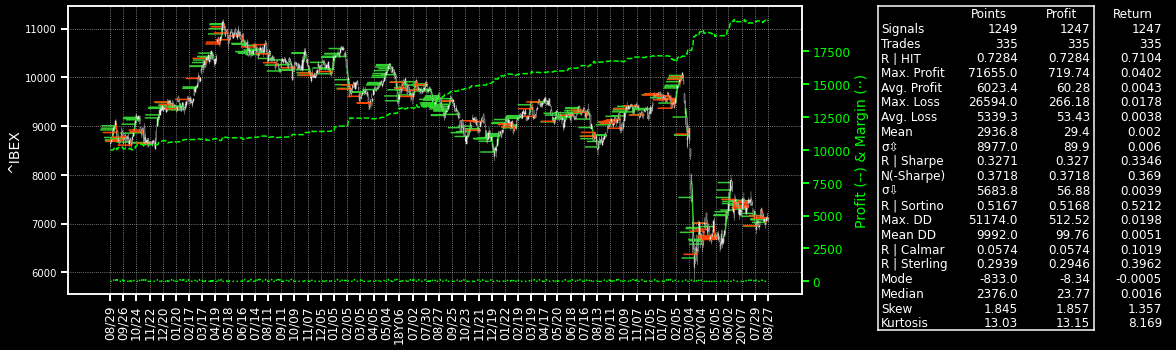

In [9]:
X1b = Exercise_1(SMAs = [3, 4, 5])
Fig1b = X1b.plot_complete(symbol = symbol, signals = False, trades = True, balance = True);

Though it's far from being perfect, Sharpe ratio and mean profit for M5 have massively improved... Around **33x**!

<u>**Conclusion**</u>: Consider first, that we are longing/shorting an index (IBEX) worth around 10-20 dollars per contract. Therefore, due to the time range that we are analyzing (14 days), it's quite justifiable, I'd say, the low mean profit and Sharpe ratio that this backtest has exhibited.

However, most of the trades are negative or around zero, as seen on the histograms. This is a typical case of the commonly seen spurious signals being executed as candles slightly touch the boundaries of the SMA area and go back inside, triggering a trade and closing it briefly after. That's why we have numerous red lines on the chart plot: very short lived trades which closed on loss. These are momentum strategies, and tend to work badly when market moves in a range (horizontally).

On the other hand, when the price breaks out from the SMA band and holds the direction (momentum, impulse), there's a clearly defined trend, and the trade becomes profitable and much long-lived. Hence, the long green lines in the price chart. That's why we have a pretty good profit growth around the first 2 week-days, and decaying later up to Friday.

There's also another fact: trades trigger when somehow, price trends out of the SMA band. It's much more of an effort for the price to surge when the band is wide, rather than when it's not. A wider band manifests when SMA periods are too far apart. That's why, usually, closer periods generate a much more positively steep and stable profit curve, what results in higher Sharpes and Sterlings: the trades become fewer, longer, more sustainable, and less spurious.

<hr><hr><hr>

### Exercise 2

> * Buy the stock on the 4th day open, if the stock closes down consecutively for
3 days.
> * Exit on the next day open.
> * <u>Optional</u>: Optimise the strategy by exiting the long position on the same day close.

> Also, you can optimise the number of down days.<br>
> There are high chances that the number of down days would be different for each stock.

This exercise is a typical daily-buy-and-hold strategy which aims to look for trend reversals. To try the "``optimap``" function in a labelled set of parameters, we will feature a few non-numerical arguments:
* The ability to choose a trade ``closer`` price: Exit trade at next day's ``Open``, or at same day's ``Close``.
* The ability to enter a ``short`` trade rather than to always buy when the indicated number of ``bear_days`` is met.

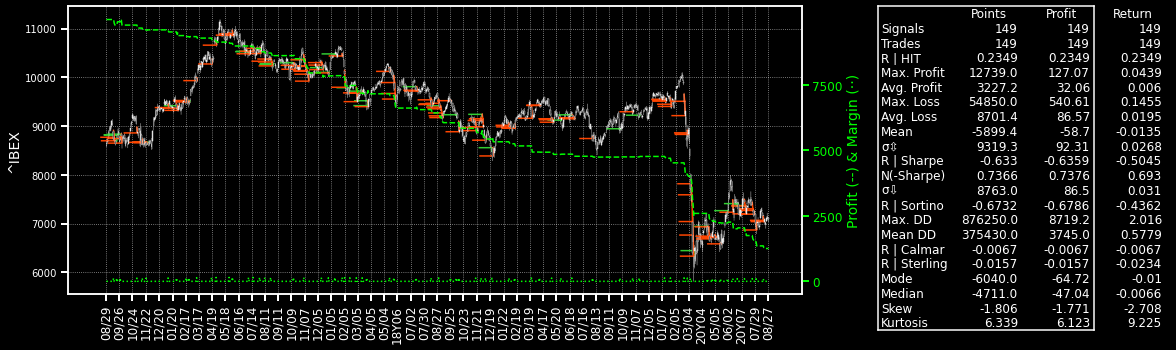

In [10]:
def Exercise_2(bear_days, closer = "Open", short = False):
    ####################################################################################### Indicators.
    X = Original_Data.clone(name = "[Exercise 2] Buy at the n'th bull day.") ## Create backtesting instance.
    X.Data[("Indicators", "isBear")] = (X.Data[dataset]["Close"] < X.Data[dataset]["Open"]) ## True if bear.
    X.Data[("Indicators", "Count")] = X.Data["Indicators"]["isBear"].rolling(bear_days).sum() # Count bear...
    X.Data[("Indicators", "Count")] = X.Data["Indicators"]["Count"].fillna(0).astype(int)  # ...successive days.
    ####################################################################################### Signals.
    rule_entry = lambda x: (x["Indicators"]["Count"] >= bear_days) ## When count of recent days are all "bear_days"...
    rule_close = lambda x: (x[symbol]["SS" if short else "LB"] > 1) ## When there was a buy signal yesterday,
    # Note: Don't change "f_size" if wishing to increase all trade sizes. Directly increase "lot" in "Account".
    shift = 1*(closer == "Open")
    X.load_signal(symbol, dire = ("SS" if short else "LB"), trig = (dataset, "Open"), rule = rule_entry)
    X.load_signal(symbol, dire = ("SB" if short else "LS"), trig = (dataset, closer), rule = rule_close, shift = shift)
    X.Data[(symbol, "SB" if short else "LS")] = X.Data[symbol]["SB" if short else "LS"].shift(1 - shift)
    ####################################################################################### Strategy testing.
    X.test_strategy(max_trades = 1)   ;   X.test_balance(**Account)   ;   X.test_stats()
    return X
## Strategy test.
X2a = Exercise_2(bear_days = 3) ## Change amount of bear days to trade, in this argument.
Fig2a = X2a.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
matplotlib.pyplot.pause(1e-13) ## This solves some pretty long Tkinter warning that prints.

As we can see, this strategy is pretty poor. Only 23% of the trades were positive, and much less profitable on average than the losing ones. Also, as we shall always have one signal per candle at most, and at the same time, the strategy conceives trades of one-day lifespan, all (``149``) signals are turned into trades. Indicator plotting is not worth much because it's just a candle counter and a boolean condition with no graphical value.

We can see below, some of the dataset rows and resulting trades...

In [11]:
ttl = "Trades: points, PnL & margin summary"   ;   print(ttl + "\n" + "‾"*len(ttl))  ;   display(X2a.Trades.iloc[show])

Trades: points, PnL & margin summary
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


Time              Price            Sym Dir Size    Sink   Cause  \
          Open      Close    Open   Close                                   
0   2016-09-13 2016-09-14  8907.2  8769.9  ^IBEX   L    1  8684.2  Signal   
1   2016-09-14 2016-09-15  8769.9  8697.0  ^IBEX   L    1  8665.4  Signal   
2   2016-09-20 2016-09-21  8695.1  8817.0  ^IBEX   L    1  8695.1  Signal   
146 2020-07-31 2020-08-03  7025.2  6867.4  ^IBEX   L    1  6788.9  Signal   
147 2020-08-17 2020-08-18  7141.5  7065.7  ^IBEX   L    1  7024.4  Signal   
148 2020-08-18 2020-08-19  7065.7  7039.1  ^IBEX   L    1  7002.8  Signal   

    Points                 Profit                     Return          Margin  \
                 Σ   Sink                Σ   Abs.DD           Rel.DD           
0   -13731  -13731  22300 -137.31  9862.69     0.00   -1.38%    0.0%  123.71   
1    -7290  -21021  10450  -72.65  9790.04    72.64   -0.74%   0.73%  121.80   
2    12189   -8832      0  121.66  9911.70     0.00    1.24%    0.0%  120.76   
146 -15781 -868762  23630 -155.88  1354.01  8618.41  -10.33%  86.42%   97.57   
147  -7581 -876343  11710  -73.78  1280.24  8692.18   -5.45%  87.16%   99.18   
148  -2660 -879003   6289  -26.22  1254.02  8718.40   -2.05%  87.42%   98.13   

                    
          Σ  Level  
0    123.71  7903%  
1    121.80  8011%  
2    120.76  8106%  
146   97.57  1305%  
147   99.18  1247%  
148   98.13  1240%

In [12]:
ttl = "Price/volume data, signals & indicators"   ;   print(ttl + "\n" + "‾"*len(ttl))  ;   display(X2a.Data.iloc[show])

Price/volume data, signals & indicators
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


Symbol     ^IBEX D1                                     ^IBEX            \
Value          Open    High     Low   Close     Volume Spread  LB    SS   
Date                                                                      
2016-08-29   8611.2  8660.9  8573.7  8616.4   98605500    0.0 NaN  None   
2016-08-30   8629.4  8731.9  8629.0  8685.4  155905500    0.0 NaN  None   
2016-08-31   8677.4  8780.7  8671.4  8716.8  297356800    0.0 NaN  None   
2020-08-26   7088.4  7136.5  7070.4  7123.0  122064500    0.0 NaN  None   
2020-08-27   7114.1  7130.2  7029.2  7090.7  162183000    0.0 NaN  None   
2020-08-28   7114.7  7162.9  7055.1  7133.0  193354864    0.0 NaN  None   

Symbol                   Indicators        
Value           LS    SB     isBear Count  
Date                                       
2016-08-29  8611.2  None      False     0  
2016-08-30     NaN  None      False     0  
2016-08-31     NaN  None      False     0  
2020-08-26     NaN  None      False     1  
2020-08-27     NaN  None       True     2  
2020-08-28     NaN  None      False     1

So we've got four possible strategy methodologies according to the arguments we've specified aside from the ``bear_days``' counter. The "``cases``"' dict pretty much describes them. As there's no ordinal continuity between cases because they are pretty much methodologically independent from each other, a ``heat``map would prove worthless. It's better to plot them with a line which spans through the different ``bear_days``' backtested thresholds.

See that as each labelled case (``keys``) case holds an internal dict (``values``) which contains the argument keywords for "``Exercise_2``" function, Python's ``dict`` unwrapping ("``**y``") may be enough for the function to comprehend the corresponding argument values for each case. And in fact, it does work!

In [13]:
% # [Delete this line to enable execution of this cell]
cases = {"Buy, sell next day": {"closer": "Open", "short": False}, "Buy, sell same day": {"closer": "Close", "short": False},
         "Sell, buy next day": {"closer": "Open", "short": True},  "Sell, buy same day": {"closer": "Close", "short": True}}
Fig2o, Grid2 = optimap(f_xy = lambda x, y: Exercise_2(bear_days = x, **y),
                X_params = range(1, 10), Y_params = cases, heat = False);

UsageError: Line magic function `%` not found.


<center><img src = " https://drive.google.com/uc?id=1llr0WFRP-XOEEg5A7zGKy9rHHYS-t9Kj" width = "80%"></img></center>

So we've found that this strategy is **extremely** better when reformulating it as a trend-continuation seeker: If we sell when "``n``" bear days have passed and buy at the same day's ``Close``, the results are incredibly more profitable as the red curve implies. In fact, keeping the ``bear_days``' threshold in "``n = 3``" shows an almost **perfect** hit ratio!!

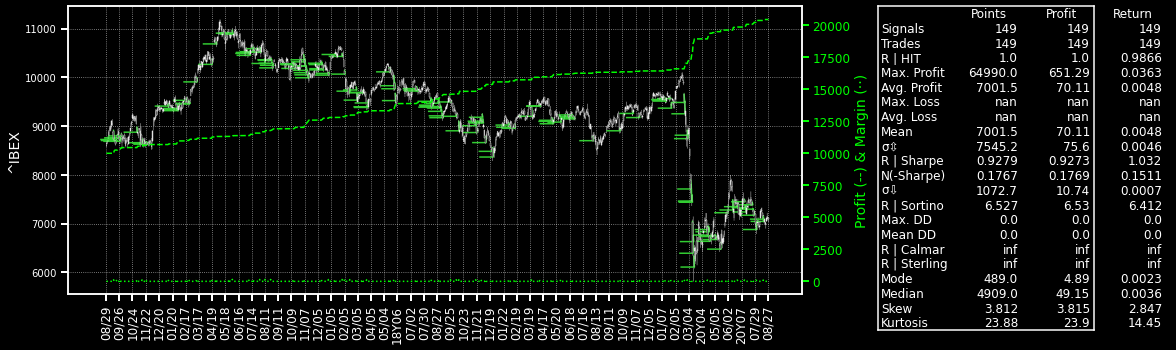

In [14]:
X2b = Exercise_2(bear_days = 3, closer = "Close", short = True)
Fig2b = X2b.plot_complete(symbol = symbol, signals = False, trades = True, balance = True);

<hr><hr><hr>

### Exercise 3

> * Buy long on the instrument such as Nifty or SPY when the RSI is less than 15.
> * Exit (sell) conditions: RSI > 75. Stops: SP of 5%, SL of 2%.
> * <u>Optional</u>: Optimise the strategy by adjusting the RSI value. SP and SL criteria can be different for each stock.

In this case, we've got the following optimizable parameters:
* The RSI ``period``, wholly numerical. (Default: ``14``)
* The RSI buying ("``_L``") and selling ("``_S``") values, also wholly numerical. (Default: ``15`` and ``75``).
<br>The middle "idle" zone has width equal to "``RSI_S - RSI_B``" and is centered at "``(RSI_S + RSI_B)/2``".
* The ``SP`` and ``SL`` values given as percentages of the trade entry price, also numerical.
* I'll personally add a 4th non-numerical factor to define the available ``trade``s: ``L``ong and/or ``S``hort.

Two important details:
* Given "idle" zone width "``y``" and centered at RSI equal to "``50``", it can be proven that: "``RSI_B = 50 - y/2``" and "``RSI_S = 50 + y/2``". 
* Such width must always be less than 100. But when negative, we invert trade direction: now it buys at the upper line, and sells at the lower one.

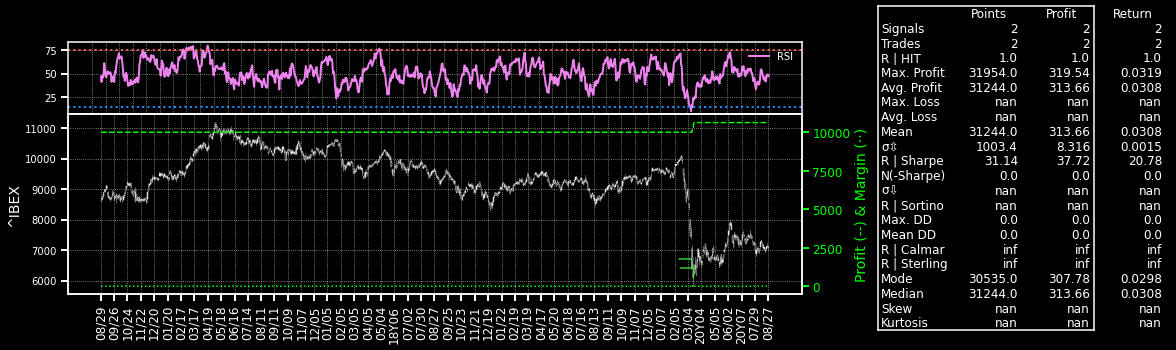

In [15]:
def Exercise_3(period, trade = "L", RSI_B = 15, RSI_S = 75, SP = 0.05, SL = 0.02):
    ####################################################################################### Indicators.
    RSI = ("Indicators", "RSI")
    X = Original_Data.clone(name = "[Exercise 3] RSI long band")
    X.Data[RSI] = ta.momentum.rsi(X.Data[dataset]["Close"], n = period)
    ####################################################################################### Signals.
    H_rule = lambda x: (x[RSI] > max(RSI_B, RSI_S))  ## High signal is triggered whenever RSI goes above the upper line.
    L_rule = lambda x: (x[RSI] < min(RSI_B, RSI_S))  ## Low signal is triggered whenever RSI goes below the upper line.
    if ("L" in trade): ## When we look for reversals: "low RSI < RSI_B < RSI_S". For trends: "RSI_S < RSI_B < high RSI".
        X.load_signal(symbol, dire = "LB", trig = (dataset, "Close"), rule = L_rule if (RSI_B < RSI_S) else H_rule)
        X.load_signal(symbol, dire = "LS", trig = (dataset, "Close"), rule = H_rule if (RSI_B < RSI_S) else L_rule)
    if ("S" in trade):
        X.load_signal(symbol, dire = "SS", trig = (dataset, "Close"), rule = H_rule if (RSI_B < RSI_S) else L_rule)
        X.load_signal(symbol, dire = "SB", trig = (dataset, "Close"), rule = L_rule if (RSI_B < RSI_S) else H_rule)
    TradeInfo = {"SP": (lambda row, _: row[dataset]["Close"]*SP), "SL": (lambda row, _: row[dataset]["Close"]*SL)}
    ####################################################################################### Strategy testing.
    X.test_strategy(max_trades = 1, **TradeInfo)   ;   X.test_balance(**Account)   ;   X.test_stats()
    ####################################################################################### Results.
    return X
## Strategy test.
X3a = Exercise_3(period = 14) ## Change RSI period value in this list.
Fig3a = X3a.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
P = Fig3a.axes[0].get_position()  ;   Fig3a.axes[0].set_position([P.x0, P.y0, P.width, 0.5])
Ax3a = Fig3a.add_axes([P.x0, P.y0 + 0.5, P.width, 0.2])  ;  Ax3a.set_zorder(-10)
Ax3a = X3a.plot_indicator(axes = Ax3a, labels = "RSI", color = "violet", linewidth = 2)
Ax3a.axhline(y = 15, linestyle = ":", linewidth = 2, color = "dodgerblue"); ## Upper threshold.
Ax3a.axhline(y = 75, linestyle = ":", linewidth = 2, color = "tomato");     ## Lower threshold.

As presented, the strategy seems to be profitable but its trades are scarce so results are hardly "believable". To increase trade frequency, one could...
* Decrease RSI ``period`` so as to decrease its damping factor and make it more "oscillating".
* Increase "``RSI_B``" and decrease "``RSI_S``". Tightening the idle band's width flexibilizes conditions for signal generation.
* Decrease "``SL``" and "``SP``" percentages, to force a shorter trade's lifespan.

Well, it can be proven by repeated backtests that though sample density increases as desired, profitability doesn't get any better. We can make a first use of "``optimap``" ``Grid``s with low resolution with the intention of looking for those parameters which can maintain profitability while increasing trade frequency. The areas with better performances show up on the oblique lower/upper edges of the graph, and the combinations with high trade density lean on the leftmost border. However, trend-driven trades in general (negative "width": "``RSI_B > RSI_S``") perform slightly better than the original strategy.

In [16]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_3(period = x, RSI_B = 50 - y/2, RSI_L = 50 + y/2)
Fig3o1, Grid31 = optimap(f_xy = f_xy, X_params = range(4, 66, 2), Y_params = numpy.r_[-80:-9:10, 10:81:10]);

UsageError: Line magic function `%` not found.


<center><img src = " https://drive.google.com/uc?id=1bM2xq1xvIzbkBvN6QM2hnBDJuToXmO2p" width = "100%"></img></center>

After a few tests, I've witnessed the most balanced configurations to be around the square marked in purple, with periods ``4-6`` and idle zone widths around ``-50`` (trend-trading). These strategies accomplish a reasonable amount of trades while keeping at least a positive Sharpe ratio. Remember that the standard deviation per trade is inversely proportional to the square root of the amount of trades, so low Sharpe ratios can be compensated with not-so-low trade frequencies.

We can now look for another optimap around these "warm" areas but calibrating the stop values "``SP``" and "``SL``" as the new "``X_params``" and "``Y_params``". The results for them being between 0.5% and 7.5% are shown below. Mind that "``RR = SP/SL``" is the risk-reward ratio.

In [17]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_3(period = 6, RSI_B = 75, RSI_L = 35, SP = x, SL = y)
Fig3o2, Grid32 = optimap(f_xy = f_xy, X_params = numpy.r_[0.5:8:0.5], Y_params = numpy.r_[0.5:8:0.5]);

UsageError: Line magic function `%` not found.


<center><img src = "https://drive.google.com/uc?id=1BGIe6sjhAmztazPQSW9KGaBOdrpNu8zm" width = "100%"></img></center>

In these figures, 3 warm areas can be found at the following locations:

<center><table class = "square">
<tr><th><u>SP</u></th><th><u>SL</u></th><th><u>Trades</u></th><th><u>Hits</u></th><th><u>Sharpe</u></th>
<th><u>Sterling</u></th><th><u>Sharpe (ideal)</u></th></tr>
<tr><td>  6%  </td><td>   3% </td><td>  15  </td><td> 47% </td><td>  0.17  </td><td>  0.11  </td><td>  0.06  </td></tr>
<tr><td>  3%  </td><td>   3% </td><td>  28  </td><td> 57% </td><td>  0.15  </td><td>  0.07  </td><td>  0.05  </td></tr>
<tr><td>  1%  </td><td> 1.5% </td><td>  38  </td><td> 63% </td><td>  0.16  </td><td>  0.17  </td><td>  0.05  </td></tr>
</table></center>

In spite of having similar Sharpe ratios are pretty similar from each other, the last line has a slightly better trading frequency than the others, and a higher Sterling (lower drawdown). That's curious because the risk-reward ratio seems disadvantageous. The higher 63% hit ratio makes up for this. Ideally (without transaction costs), the theoretical Sharpe ratio for all trades being closed by stop values, is calculated as:
$$ \mu = SP \times H - SL \times (1 - H) \qquad\qquad \sigma = H(1 - H) \times (SP + SL)^2 \qquad\qquad Sharpe = \mu/\sigma $$

As long as the hit ratio holds still throughout time, the 3 strategies might have more or less the same performance. Though, they are still quite poor. So I will take the chance to use the 4th feature in the exercise: the addition of short trades to our strategy. The main reason is because it can be clearly seen that the most profitable trades are trend-based, and appear during early 2017 where market is strongly bullish, as the next figure shows. Therefore we could maybe catch the bearish trend that endures during 2018 and 2020 if the strategy triggers shorting trades as well.

<center><img src = "https://drive.google.com/uc?id=1lQlN7W09klQ9jNxEe-h9dPfqwrIq-5t1" width = "100%"></img></center>

So after testing the same strategy but with both buying and selling trades, we find that it is quite more balanced than before. The zone of high trade density has widened as expected, and there are similar hot spots with extremely high Sharpe values on the upper edges like before, due to scarse winning trades, which though do not conceive any useful statistical value.

In [18]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_3(period = x, RSI_B = 50 - y/2, RSI_L = 50 + y/2, trade = "LS") ## Long & Short.
Fig3o3, Grid33 = optimap(f_xy = f_xy, X_params = range(4, 66, 2), Y_params = numpy.r_[-80:-9:10, 10:81:10]);

UsageError: Line magic function `%` not found.


<center><img src = "https://drive.google.com/uc?id=1raCKlGJTsLi4u54VYopqEsxQPYZ7ESn-" width = "100%"></img></center>

Special attention should be paid to the upper leftmost large orange triangle on the Sharpe map, of period around ``4-15`` and idle zone width around positive ``10-50``. Should we keep the ``period`` equal to ``6`` as previously, together with a width equal to ``30`` (around the orange patch center), let's see what happens with the stop values.

In [19]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_3(period = 6, RSI_B = 35, RSI_L = 65, SP = x, SL = y, trade = "LS") ## Long & Short.
Fig3o4, Grid34 = optimap(f_xy = f_xy, X_params = numpy.r_[0.5:8:0.5], Y_params = numpy.r_[0.5:8:0.5]);

UsageError: Line magic function `%` not found.


<center><img src = "https://drive.google.com/uc?id=1kc-r2vvRjh7KIpdyy-2X7CXLAPtrSisu" width = "100%"></img></center>

After some backtests on the hottest areas on the upper right, it can be seen that most Sharpe and Sterling ratios are both above 0.2. Quite an improvement, considering that the amount of trades has also vastly increased to around 75 at the very least. So our final optimizing configuration could be, for the same period and idle width, stop values "``SP/SL = 6/6``". Appreciate the much more attractive results below...

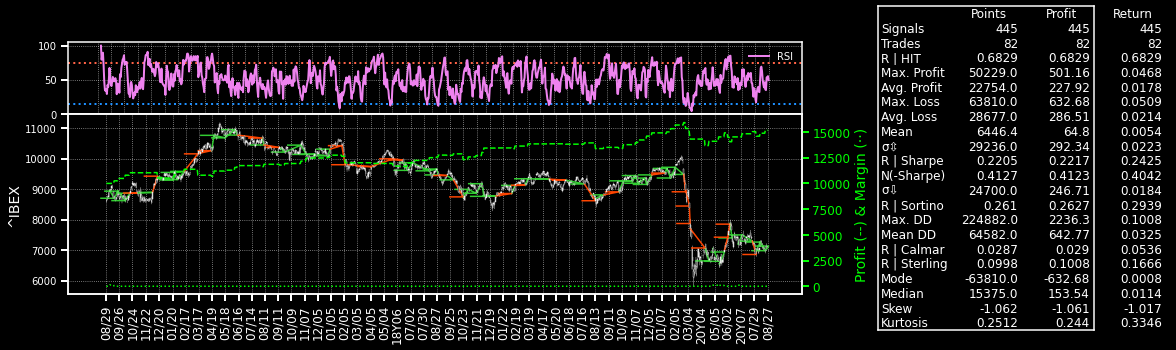

In [20]:
## Strategy test.
X3b = Exercise_3(period = 6, RSI_B = 35, RSI_S = 65, trade = "LS", SP = 0.06, SL = 0.06)
Fig3b = X3b.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
P = Fig3b.axes[0].get_position()  ;   Fig3b.axes[0].set_position([P.x0, P.y0, P.width, 0.5])
Ax3b = Fig3b.add_axes([P.x0, P.y0 + 0.5, P.width, 0.2])  ;  Ax3b.set_zorder(-10)
Ax3b.axhline(y = 15, linestyle = ":", linewidth = 2, color = "dodgerblue"); ## Upper threshold.
Ax3b.axhline(y = 75, linestyle = ":", linewidth = 2, color = "tomato");     ## Lower threshold.
Ax3b = X3b.plot_indicator(axes = Ax3b, labels = "RSI", color = "violet", linewidth = 2)

<hr><hr><hr>

### Before going on...

Both exercises 4 and 5 use moving price extremes as signal generators. Classical technical analysis defines the "Donchian channel" indicator as the zone between the bands ("``hband``" and "``lband``") that interconnect all rolling highest and lowest values respectively. Usually these bands have equal lookback periods, but ``Exercise_4`` conceives them as independent and separate parameters ("``period_min``" & "``period_max``"). Python's "``ta``" library includes Donchian channels as a ``volatility`` indicator, so we'll use that.

Note that the ``offset`` argument in this indicator measures from which past price backwards we are measuring said moving extremes: it moves the band to the left (can't move rightwise because that would mean looking into the future). We need an "``offset = 1``" so as not to include the last price candle in the channel measurement. Otherwise, the actual price range would never be able to break out of the channel.

So: when the actual price candle breaks out of the channel, it's because:
* ("<u>``H_rule``"</u>) The candle crossed the upper Donchian ``hband``: its ``High`` went over "``D+``".
* ("<u>``L_rule``"</u>) The candle crossed the lower Donchian ``lband``: its ``Low`` went under "``D-``".

These two rules can either serve as entry or close signals for either long or short trades, depending on our particular strategy configuration. We will thus enable two additional arguments, "``trade``" and "``rev``". Their principle is described in the table below. (Notice that "``trade = "LS"``" would search for both ``L``ong and ``S``hort trades.)

<center><img width = 33% src = "https://drive.google.com/uc?id=1jz0BPTd6GN7UvF82-tFl6WzNhXiOsp3Y"></img></center>

On the other hand, we've got the "``ATR``" indicator which was originally used as volatility metric to which stop profit/loss values are proportionally sized in the "turtle trading strategy" from class EFS-02. As the "``Backtest.ipynb``" framework presented in this project is already event-oriented, we can take advantage from this.

In [21]:
def Exercise_4_and_5(X, period_DH, period_DL, period_ATR, xSL, xSP, rev, trade):
    ####################################################################################### Indicators.
    H, L, C = X.Data[dataset]["High"], X.Data[dataset]["Low"], X.Data[dataset]["Close"]
    X.Data[("Indicators", "D+")] = ta.volatility.donchian_channel_hband(H, L, C, n = period_DH, offset = 1)
    X.Data[("Indicators", "D-")] = ta.volatility.donchian_channel_lband(H, L, C, n = period_DL, offset = 1)
    ####################################################################################### Signals.
    H_rule = lambda x: x["Indicators"]["D+"] < x[dataset]["High"]
    L_rule = lambda x: x["Indicators"]["D-"] > x[dataset]["Low"]
    if ("L" in trade): ### Entry, buy long.
        X.load_signal(symbol, dire = "LB", trig = ("Indicators", "D-" if rev else "D+"), rule = (L_rule if rev else H_rule))
    if ("S" in trade): ### Entry, sell short.
        X.load_signal(symbol, dire = "SS", trig = ("Indicators", "D+" if rev else "D-"), rule = (H_rule if rev else L_rule))
    if ("L" in trade) and (period_ATR == 0): ### Exit long by signal. Don't use stops/ATR.
        X.load_signal(symbol, dire = "LS", trig = ("Indicators", "D+" if rev else "D-"), rule = (H_rule if rev else L_rule))
    if ("S" in trade) and (period_ATR == 0): ### Exit short by signal. Don't use stops/ATR.
        X.load_signal(symbol, dire = "SB", trig = ("Indicators", "D-" if rev else "D+"), rule = (L_rule if rev else H_rule))
    ####################################################################################### Stop management.
    TradeInfo = {"SL": None, "SP": None, "size": None}
    if (period_ATR > 0): ## If we don't wish to use none of the stop values, we can just set this to zero.
        X.Data[("Indicators", "ATR")] = ta.volatility.average_true_range(H, L, C, n = period_ATR, fillna = True)
        if (xSL > 0): TradeInfo["SL"] = lambda row, _: row["Indicators"]["ATR"]*xSL ## "xSL = 0" -> SL won't apply.
        if (xSP > 0): TradeInfo["SP"] = lambda row, _: row["Indicators"]["ATR"]*xSP ## "xSP = 0" -> SP won't apply.
    ####################################################################################### Strategy testing.
    X.test_strategy(max_trades = 1, **TradeInfo)   ;   X.test_balance(**Account)   ;   X.test_stats()
    ####################################################################################### Results.
    return X

<hr><hr><hr>

### Exercise 4

> Backtest the strategy based on the turtle trading system covered in EFS-02 class. You can use the daily data for backtesting purpose. Also, the event-driven approach covered in DMP-01 and DMP-03 would be best for this scenario.

For this case, pretty much all of the numerical (``float`` type) arguments need to be calibrated. Let's test the same config as in the original Excel assignment.

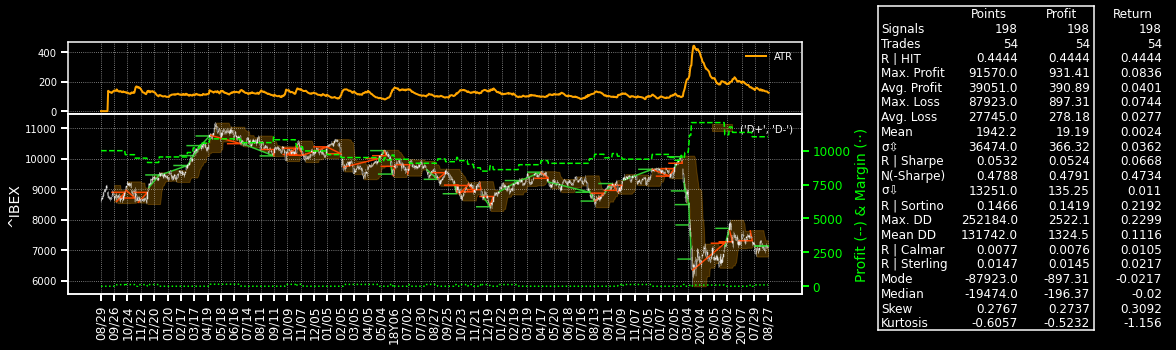

In [22]:
def Exercise_4(period_DH, period_DL, period_ATR, xSL, xSP):
    X = Original_Data.clone(name = "[Exercise 4] Turtle trading methods")
    return Exercise_4_and_5(X, rev = False, trade = "LS", xSL = xSL, xSP = xSP,
         period_DH = period_DH, period_DL = period_DL, period_ATR = period_ATR)
###################################################################################
X4a = Exercise_4(period_DH = 20, period_DL = 20, period_ATR = 12, xSL = 2, xSP = 3)
Fig4a = X4a.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
Ax4a = X4a.plot_indicator(axes = Fig4a.axes[0], labels = ("D+", "D-"), color = "orange", alpha = 1/4)
if ("Indicators", "ATR") in X4a.Data.columns:
    P = Fig4a.axes[0].get_position()  ;   Fig4a.axes[0].set_position([P.x0, P.y0, P.width, 0.5])
    Ax4a = Fig4a.add_axes([P.x0, P.y0 + 0.5, P.width, 0.2])  ;  Ax4a.set_zorder(-10)
    Ax4a = X4a.plot_indicator(axes = Ax4a, labels = "ATR", color = "orange", linewidth = 2)

As evident, the strategy is disadvantageous and highly volatile too. Also, the trading frequency is borderline, and should be increased. As seen on ``Exercise_5``, the Donchian channel bands work much better as effective support and resistance markers more like for reversals, rather than for break-outs. On the other hand, the crash due to this year's pandemics was effectively predicted, what caused the ``Max.`` ``Profit`` trade to enact and get the profit curve back to breakeven. So as a first appreciation, this strategy could still work despite its low hit ratio, if we could force the ``Avg.`` ``Profit`` to go up (or the ``Avg.`` ``Loss`` to go down). This is obviously accomplished with finding the best stop value multipliers ("``xSL``" & "``xSP``") and the best ``period`` for our ``ATR`` indicator.

Note that for example, if we set "``period_DH = 100``" and "``period_DL = 3``", we'd have much more short trades than long. So the problem of choosing different ``period`` values for Donchian channel bands, is that we would be altering the directional preference towards one trade type inevitably. Therefore, let's keep "``period_DH = period_DL``". Testing period ("``X_params``") values for Donchian channels should be smaller than for ATR ("``Y_params``"), because we want the trading frequency not to fall.

In [23]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_4(period_DH = x, period_DL = x, period_ATR = y, xSL = 1, xSP = 1)
Fig4o1, Grid41 = optimap(f_xy = f_xy, X_params = range(2, 41, 2), Y_params = range(4, 82, 4))

UsageError: Line magic function `%` not found.


It comes to our attention that the areas in these maps are quite rectangle-ish. May be because of the staircase-like shape of the Donchian channel in terms of visual representation. The derivative of maxima and minima functions are naturally discontinuous from an analytical perspective, so it's not strange for the Donchian channel to present discrete areas, and thus the same fact applies to a heatmap that inherently depends on them.

<center><img width = 100% src = "https://drive.google.com/uc?id=1GriuXwUVOrqiBgQ71qqRuY1x-7A8d5yt"></img></center>

A particularly interesting area leans towards the rightmost upper part of the central orange ``Trades`` map. Mostly on the most exposed corner at which the arrow in "``R | Sharpe``" plot is pointing. That should be around ``26`` for the Donchian channels, and ``36`` for the ATR, which after backtesting, depicts a Sharpe ratio of 0.066 which is pretty low, though after 100 trades. Let's see what happens if we run an optimap along the different stop value proportionality constants.

In [24]:
% # [Delete this line to enable execution of this cell]
f_xy = lambda x, y: Exercise_4(period_DH = 26, period_DL = 26, period_ATR = 36, xSL = y, xSP = x)
Fig4o2, Grid42 = optimap(f_xy = f_xy, X_params = numpy.r_[1:11]/4, Y_params = numpy.r_[1:11]/4)

UsageError: Line magic function `%` not found.


This case is a bit more complex because the areas with "warm" amounts of trades are quite afar from the ones with high performances. I would like to focus on a single spot which is IMHO, the most attractive configuration found.

<center><img width = 100% src = "https://drive.google.com/uc?id=1iwfSgMZMy-pIfe5UwwAunuovKnFAVzH2"></img></center>

That is: around "``(xSP, xSL) = (1.25, 2)``": the small red triangle on the mid-upper quadrant of the ``Mean`` map. It may seem somewhat counterintuitive because of its "low" Sharpe ratio. However, that is balanced with two positive facts: a high amount of trades and a high mean profit. Both of these results imply a much higher net profit overall, despite the low (but not so low) Sharpe and Sterling ratios.

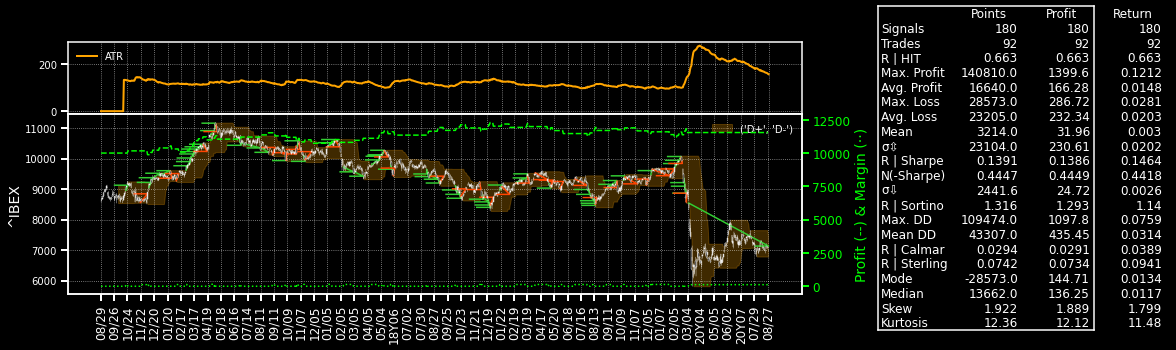

In [30]:
X4b = Exercise_4(period_DH = 26, period_DL = 26, period_ATR = 36, xSL = 2, xSP = 1.25)
Fig4b = X4b.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
Ax4b = X4b.plot_indicator(axes = Fig4b.axes[0], labels = ("D+", "D-"), color = "orange", alpha = 1/4)
if ("Indicators", "ATR") in X4b.Data.columns:
    P = Fig4b.axes[0].get_position()  ;   Fig4b.axes[0].set_position([P.x0, P.y0, P.width, 0.5])
    Ax4b = Fig4b.add_axes([P.x0, P.y0 + 0.5, P.width, 0.2])  ;  Ax4b.set_zorder(-10)
    Ax4b = X4b.plot_indicator(axes = Ax4b, labels = "ATR", color = "orange", linewidth = 2)

We can see on the figure that the growth is pretty steady and not so choppy. It has a very nice ``hit`` ratio ("$H$") and more than double the amount of trades than the strategies on the hottest Sharpe ratios on the most recent optimap. At first sight it may seem that theoretical probabilistic metrics are not that much applicable due to having a variable ``SL`` and ``SP`` this time. However, the ``ATR`` is quite constant on the graph above so we can round the real ``SL`` and ``SP`` to be approximately constants proportional to our chosen "``xSL``" and "``xSP``":
$$ \mu_{\times} = x_{SP} \; H - x_{SL} \; (1 - H) \qquad\qquad \sigma_{\times} = H\;(1 - H)\;(x_{SP} + x_{SL})^2 $$
$$ 1.25 \times 0.66 - 2 \times 0.33 = 0.16 \qquad\qquad 0.66 \times 0.33 \times (2 + 1.25)^2 = 2.3 $$
As both mean and standard deviation are proportional to the mean ``ATR``, calculating the Sharpe does cancel said factor. The latter would end up around "$ \mu_{\times}/\sigma_{\times} = 0.07$" in theory. It is lower than the real result, likely because the strategy was able to somehow predict the Spanish COVID crash and that poked that ``Max. Profit`` at the end, which may be better considered as an outlier. However, all of this at least shows that the stop value relationship is unfavourable, but that's compensated by a good enough ``hit`` ratio. And the profit grows smoothly enough to make this configuration a viable optimal.

<br><hr><hr><hr>

### Exercise 5

> Backtest a strategy based on a High & Low price.

> * Go long when the stock closes above the last 20 day’s high price.
> * Square off the long position when the stock goes below the last 20 day’s low price.
> * <u>Optional</u>: Optimise the strategy by adjusting the number of periods.
> <br>You can choose to have different number of periods for entering the long and exiting the long.

Analysis of ``Exercise_4`` was mostly concerned about the effects of stop value scaling in a breakout strategy with Donchian channels. This one will use the same indicator, but will try to discern on the directional aspect of the trades. For that, we will remove the stop value inputs so as to concentrate 100% on the relationship and interaction between the price and the Donchian bands, which are in reality the main responsibles in defining the birth and nature of the trades. We will try to focus solely on issues like...
* Should it be more convenient to sell rather than to buy?
* Should I look for trends or counter-trends?

So let's make a first backtest on a strategy involving only trend-based longs like the one in the exercise question.

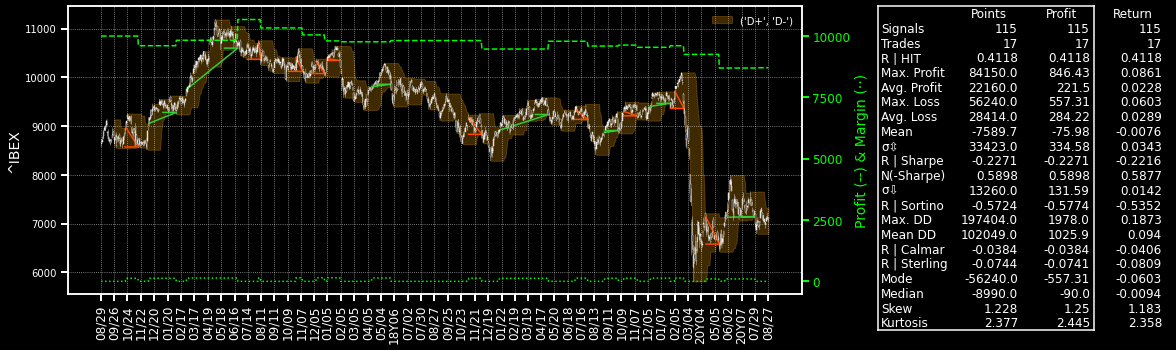

In [26]:
def Exercise_5(period, rev, trade):
    X = Original_Data.clone(name = "[Exercise 5] Open at max, close at min")
    return Exercise_4_and_5(X, period_DH = period, period_DL = period,
           period_ATR = 0, xSL = 0, xSP = 0, rev = rev, trade = trade)
###################################################################
X5a = Exercise_5(period = 20, rev = False, trade = "L")
Fig5a = X5a.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)
Ax5a = X5a.plot_indicator(axes = Fig5a.axes[0], labels = ("D+", "D-"), color = "orange", alpha = 1/4)

The outcomes are quite bad at least for this dataset. It has a poor hit ratio and a low number of trades. This exercise is pretty similar to the 2nd one: Not only trade direction can be toggled ("``short``"), but the context in which they are triggered can also be inverted ("``rev``"). So we've got 4 possibilities, as the figure on the previous paragraph clarifies. So we'll use a nested "``Y_params``" ``dict`` in our upcoming "``optimap``" which will be line-based ("``heat = False``"). Each one of the specified ``cases`` inside the former, will include a unique combination of "``rev``" and "``short``".

In [27]:
% # [Delete this line to enable execution of this cell]
cases = { "Buy at D+":  {"trade": "L", "rev": False}, "Buy at D-":  {"trade": "L", "rev": True},
          "Sell at D-": {"trade": "S", "rev": False}, "Sell at D+": {"trade": "S", "rev": True}}
Fig5o, Grid5o = optimap(f_xy = lambda x, y: Exercise_5(period = x, **y),
                X_params = range(1, 40), Y_params = cases, heat = False)

UsageError: Line magic function `%` not found.


There's always much more probable for an actual price candle to break free from the activity zone of recent prices, in comparison to the ones from the distant past. Therefore, it's logical for the amount of ``Trades`` to be higher at lesser ``Donchian channel periods``, which enclose a shorter span of min-max levels. Well, this effect has actually been seen on the majority of indicators dealt with in these exercises.

<center><img width = 100% src = "https://drive.google.com/uc?id=19wE9L7Nu6oP5w_0T3-mED9gPW_Va3h9p&"></img></center>

Regarding the configuration ``cases``: it's quite notable how reversal strategies work much better. The red and yellow lines, which represent short and long reversal trades, are higher on the areas with more than 25 trades (up to "``period = 15``", more or less). In fact, as the market has been slightly bullish on the majority of the dataset timeline, it's the short reversal trade strategy which has shown the best predictive power.

The performance peak for both reversal methodologies is present around "``period = 13``".

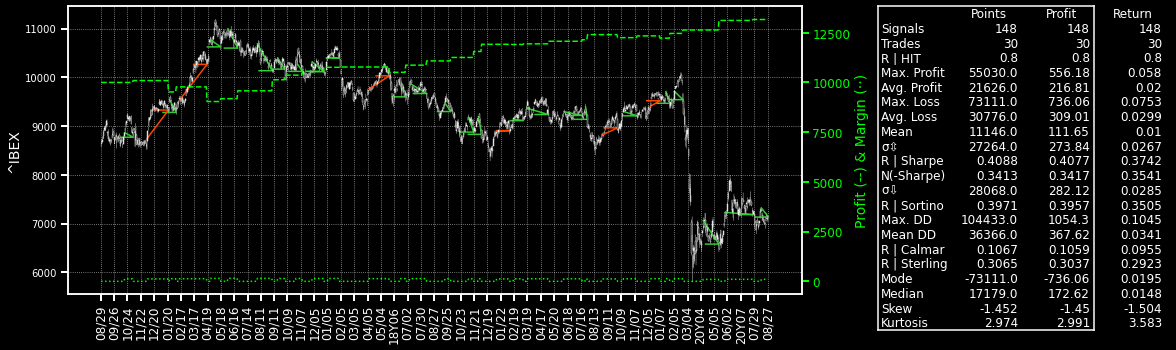

In [28]:
X5b = Exercise_5(period = 13, rev = True, trade = "S")
Fig5b = X5b.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)

The only moment in which the strategy fell down a bit, was around its most bullish moments, which is logical. However, it doesn't go long in the erratic signal that appears just before the Coronavirus' market crash. One good idea would be to imitate the improvement done in exercise 3, including both trade directions ("``trade = "LS"``"), so as to:
* Compensate the weaknesses of each other and create a much more sustainable and less variable capital growth.
* Increase the amount of trades even more, which should increase statistical validation of the trading system.
* Add up the effects of both (red and yellow) Sharpe ratios, maybe pushing forward a better performance overall.

Although by this change, the aforementioned event would negatively affect our capital, let's track our stats just up to 2019. We could just consider this crash to be an outlier, whose negative impact could have been avoided by an appropriately sized stop loss as in exercise 4. See that the results are more or less the same as in the only-shorting the strategy, though the drawdowns have almost halved, and the amount of signals and trades are about 2/3 higher (net profits and returns have increased by almost the same amount). Indeed, the profit curve looks undeniably smoother...

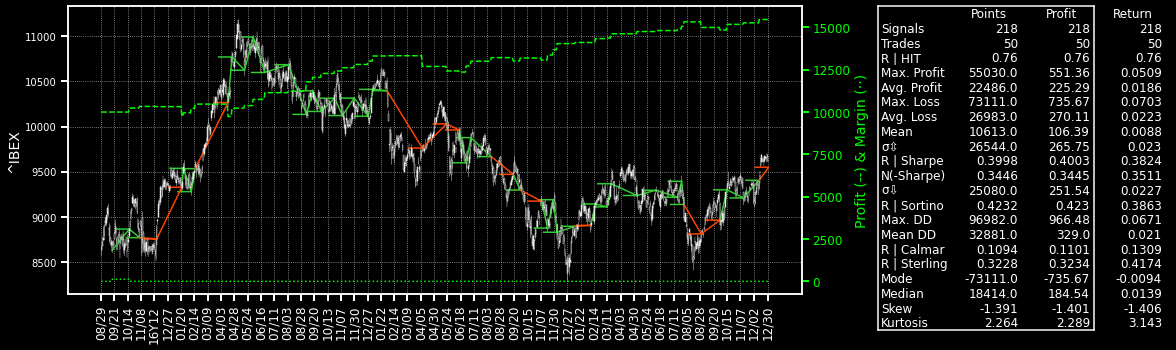

In [29]:
####################################################### Exercise resampling
def Exercise_5_no_covid(period, rev, trade):
    X = Original_Data.clone(name = "[Exercise 5] Open at max, close at min, and forget COVID")
    X.Data = X.Data.loc[:datetime.datetime(2019, 12, 31), :] ## Include up to December 2019.
    return Exercise_4_and_5(X, period_DH = period, period_DL = period,
           period_ATR = 0, xSL = 0, xSP = 0, rev = rev, trade = trade)
#######################################################
X5c = Exercise_5_no_covid(period = 13, rev = True, trade = "LS")
Fig5c = X5c.plot_complete(symbol = symbol, signals = False, trades = True, balance = True)